In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from datetime import datetime, timedelta
from PyEMD import EMD, EEMD, CEEMDAN
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from statsmodels.tsa.stattools import adfuller
from scipy.stats import ttest_1samp, t
import scipy.stats as stats
import pywt as pywt

### Step 0: Some Helper Functions and Importing Data

In [8]:
def get_stock_data(ticker, start_date, end_date):
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        return data
    except Exception as e:
        print("Error fetching data:", e)
        return None
    
def calculate_returns(data):
    returns = data.pct_change()
    returns = returns.dropna()
    return returns

def unit_root_test(imf):
    # perform ADF test
    result = adfuller(imf)
    p_value = result[1]

    return p_value

def t_test(imf, mu=0):
    # Perform one-sample t-test
    _, p_value = ttest_1samp(imf, mu)

    return p_value

def population_mean_test(data, alpha=0.05):
    # calculate the t-statistics:
    x_bar = np.mean(data)
    s = np.std(data)
    n = len(data)
    t_statistic = x_bar / (s / np.sqrt(n))

    # calculate critical values   
    t_critical_lower = stats.t.ppf(alpha/2, n-1)
    t_critical_upper = stats.t.ppf(1-alpha/2, n-1)
    
    return (t_statistic >= t_critical_lower and t_statistic <= t_critical_upper)

def adf_test(data, alpha=0.05):
    result = adfuller(data)
    p_value = result[1]
    return p_value < alpha

def get_snr(clean_signal, noisy_signal):
    clean_signal_power = np.mean(clean_signal**2)
    noise = clean_signal - noisy_signal
    noisy_signal_power = np.mean(noise**2)
    return clean_signal_power / noisy_signal_power

In [303]:
# get the ticker data
ticker = "^GSPC" # S&P500
start_dt = "2001-01-01"
end_dt = "2024-04-20"
data = get_stock_data(ticker=ticker, 
                      start_date=start_dt, 
                      end_date=end_dt)['Adj Close']

# noise characteristics
mean = 0
std_dev = 10
num_samples = len(data)
gaussian_noise = np.random.normal(mean, std_dev, num_samples)
noisy_data = data + gaussian_noise

# calculate noisy prices:
clean_price = data
noisy_price = noisy_data

# calculate returns
n = 252*5
clean_ret = calculate_returns(clean_price)[:n]
ret = calculate_returns(noisy_price)[:n]

# signal-to-noise ratio
snr_price = get_snr(clean_price, noisy_price)
snr_ret = get_snr(clean_ret, ret)
print(f"SNR (Price): {snr_price}")
print(f"SNR (Ret.): {snr_ret}")

[*********************100%%**********************]  1 of 1 completed

SNR (Price): 52718.922723452786
SNR (Ret.): 0.7451852567710128


### Step 1: Utilize ICEEMDAN to decompose the time series, resulting in IMF components and a residual component.

$$
    x(t) = \sum_{k=1}^{K} \text{IMF}_{k}(t) + R(t)
$$

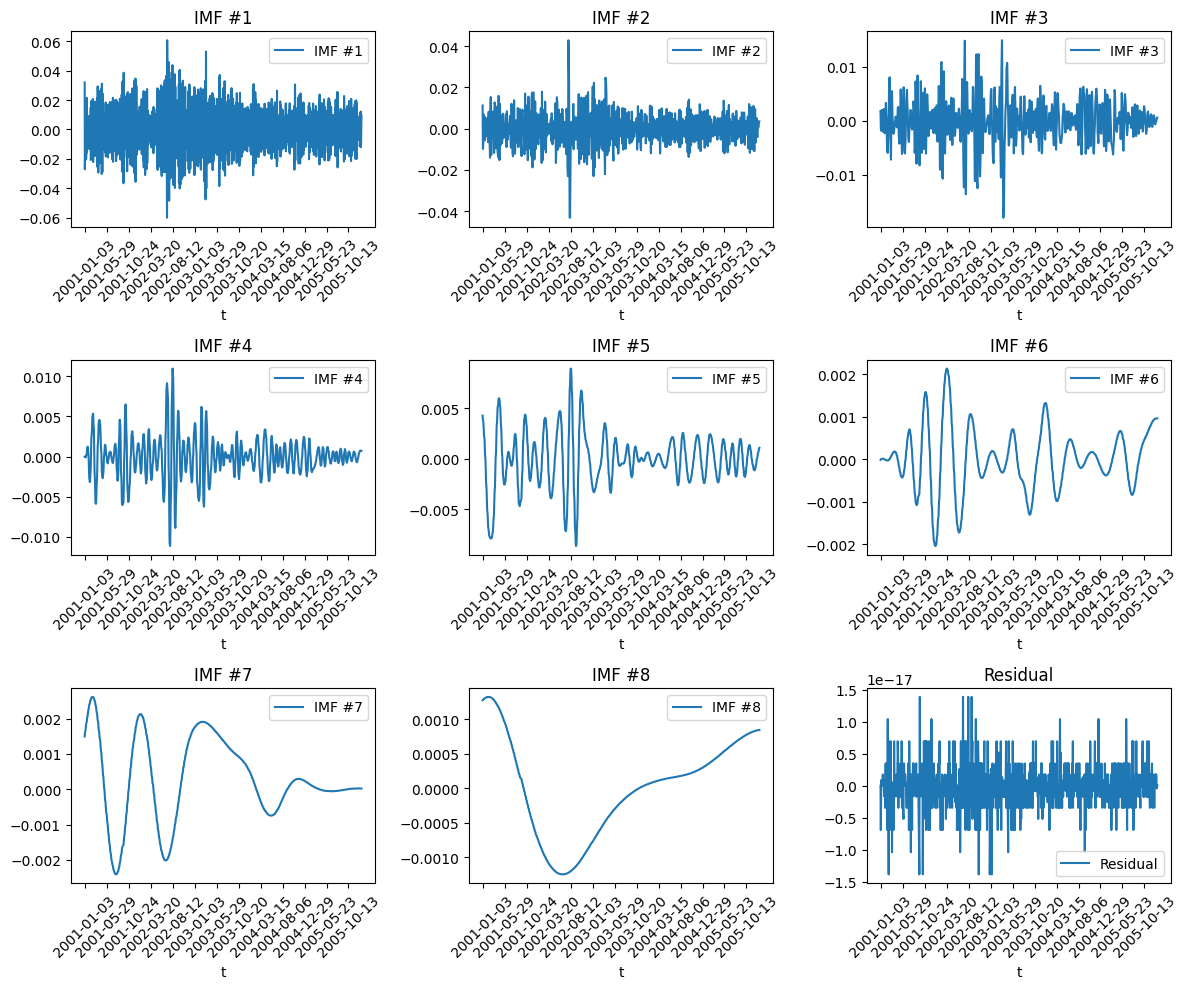

In [312]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) =  plt.subplots(3,3, figsize=(12, 10))

num=len(clean_ret)
n_dates = 100

# IMF 1
ax1.plot(t[:num], IMFs[0][:num], label="IMF #1")
ax1.set_title("IMF #1")
ax1.set_xlabel("t")
ax1.set_xticks(clean_ret.index[:num][::n_dates])
ax1.set_xticklabels(clean_ret.index[:num][::n_dates].date, rotation=45)
ax1.legend()

# IMF 2
ax2.plot(t[:num], IMFs[1][:num], label="IMF #2")
ax2.set_title("IMF #2")
ax2.set_xlabel("t")
ax2.set_xticks(clean_ret.index[:num][::n_dates])
ax2.set_xticklabels(clean_ret.index[:num][::n_dates].date, rotation=45)
ax2.legend()

# IMF 3
ax3.plot(t[:num], IMFs[2][:num], label="IMF #3")
ax3.set_title("IMF #3")
ax3.set_xlabel("t")
ax3.set_xticks(clean_ret.index[:num][::n_dates])
ax3.set_xticklabels(clean_ret.index[:num][::n_dates].date, rotation=45)
ax3.legend()

# IMF 4
ax4.plot(t[:num], IMFs[3][:num], label="IMF #4")
ax4.set_title("IMF #4")
ax4.set_xlabel("t")
ax4.set_xticks(clean_ret.index[:num][::n_dates])
ax4.set_xticklabels(clean_ret.index[:num][::n_dates].date, rotation=45)
ax4.legend()

# IMF 5
ax5.plot(t[:num], IMFs[4][:num], label="IMF #5")
ax5.set_title("IMF #5")
ax5.set_xlabel("t")
ax5.set_xticks(clean_ret.index[:num][::n_dates])
ax5.set_xticklabels(clean_ret.index[:num][::n_dates].date, rotation=45)
ax5.legend()

# IMF 6
ax6.plot(t[:num], IMFs[5][:num], label="IMF #6")
ax6.set_title("IMF #6")
ax6.set_xlabel("t")
ax6.set_xticks(clean_ret.index[:num][::n_dates])
ax6.set_xticklabels(clean_ret.index[:num][::n_dates].date, rotation=45)
ax6.legend()

# IMF 7
ax7.plot(t[:num], IMFs[6][:num], label="IMF #7")
ax7.set_title("IMF #7")
ax7.set_xlabel("t")
ax7.set_xticks(clean_ret.index[:num][::n_dates])
ax7.set_xticklabels(clean_ret.index[:num][::n_dates].date, rotation=45)
ax7.legend()

# IMF 8
ax8.plot(t[:num], IMFs[7][:num], label="IMF #8")
ax8.set_title("IMF #8")
ax8.set_xlabel("t")
ax8.set_xticks(clean_ret.index[:num][::n_dates])
ax8.set_xticklabels(clean_ret.index[:num][::n_dates].date, rotation=45)
ax8.legend()

ax9.plot(t[:num], R[:num], label="Residual")
ax9.set_title("Residual")
ax9.set_xlabel("t")
ax9.set_xticks(clean_ret.index[:num][::n_dates])
ax9.set_xticklabels(clean_ret.index[:num][::n_dates].date, rotation=45)
ax9.legend()

plt.tight_layout()
plt.savefig("imfs", dpi=300)
plt.show()

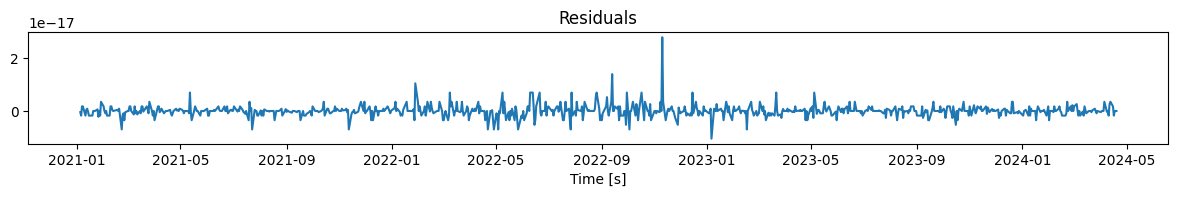

In [5]:
plt.figure(figsize=(12,2))
plt.plot(t, R,label="Residual")
plt.xlabel("Time [s]")
plt.tight_layout()
plt.title("Residuals")
plt.show()

### Step 2: Carry out t-tests and unit root tests for each IMF

$$
    \text{IMFs} = [\underbrace{\text{IMF}_{1}, \ldots,  \text{IMF}_{i}}_{\text{noise}}, \underbrace{\text{IMF}_{i+1}, \text{IMF}_{K}}_{\text{non\_noise}}]
$$

$$
\begin{align}
    \implies x(t) &= \underbrace{\sum_{k=1}^{i} \text{IMF}_{k}(t)}_{x(t)_{\text{noise}}} + \underbrace{\sum_{k=i+1}^{K} \text{IMF}_{k}(t) + R(t)}_{x(t)_{\text{non\_noise}}} \\
    &= x(t)_{\text{noise}} + x(t)_{\text{non\_noise}}

\end{align}
$$

In [6]:
results_df = pd.DataFrame(columns=['IMF', 'Unit Root Test P-value', 'T-test P-value'])

# Iterate over each IMF component
for i, imf in enumerate(IMFs):
    # unit root test
    p_value_adf = unit_root_test(imf)
    
    # t-test
    p_value_ttest = t_test(imf)
    
    # Append results to DataFrame
    results_df = pd.concat([results_df, pd.DataFrame({'IMF': [f'IMF {i+1}'], 
                                                      'Unit Root Test P-value': [p_value_adf], 
                                                      'T-test P-value': [p_value_ttest]})],
                           ignore_index=True)
p_value_adf_sum = unit_root_test(sum_IMFs)
p_value_ttest_sum = t_test(sum_IMFs)
results_df = pd.concat([results_df, pd.DataFrame({'IMF': 'sum', 
                                                      'Unit Root Test P-value': [p_value_adf_sum], 
                                                      'T-test P-value': [p_value_ttest_sum]})],
                           ignore_index=True)
results_df

,IMF,Unit Root Test P-value,T-test P-value
0,IMF 1,9.604139e-23,5.585590e-01
1,IMF 2,3.463491e-24,9.798324e-01
2,IMF 3,3.812505e-19,8.373249e-01
3,IMF 4,2.250355e-13,2.507085e-01
4,IMF 5,1.297210e-08,1.516925e-01
5,IMF 6,1.858359e-03,4.643604e-01
6,IMF 7,1.916977e-01,4.839330e-65
7,IMF 8,9.776315e-01,0.000000e+00
8,sum,0.000000e+00,2.905033e-01


In [241]:
# population test for mean:
x = IMFs[0]
x_bar = np.mean(x)
s = np.std(x)
n = len(x)

# choose significance level
alpha = 0.10

# calculate the test statistic:
t_statistic = x_bar / (s / np.sqrt(n))
t_critical_lower = stats.t.ppf(alpha/2, n-1)
t_critical_upper = stats.t.ppf(1-alpha/2, n-1)
if (t_statistic >= t_critical_lower and t_statistic <= t_critical_upper):
    print("Accept H0 i.e mean=0")
else:
    print("H0 Rejected i.e. mean != 0")

Accept H0 i.e mean=0


In [8]:
# Augmented Dickey-Fuller Test for testing stationarity:
x = IMFs[0]
adf_test(x)

True

$$
\begin{align}
    x(t)_{\text{noise}} &= \sum_{k=1}^{i} \text{IMF}_k(t) \\
    x(t)_{\text{non\_noise}} &= \sum_{k=i+1}^{K} \text{IMF}_k(t) + R(t) \\
\end{align}
$$

In [246]:
separation_point = None
test_results = []

# Iterate over possible separation points
for i in range(1, len(IMFs)):
    # Condition 1: Population mean test for each IMF component
    condition_1 = all(population_mean_test(imf, 0.20) for imf in IMFs[:i])
    
    # Condition 2: Population mean test for the sum of IMF components
    condition_2 = population_mean_test(np.sum(IMFs[:i], axis=0),  0.20)
    
    # Condition 3: ADF test for each IMF component
    condition_3 = all(adf_test(imf, 0.20) for imf in IMFs[:i])
    
    # Condition 4: ADF test for the sum of IMF components
    condition_4 = adf_test(np.sum(IMFs[:i], axis=0), 0.20)
    
    # Store the test results
    test_results.append((i, condition_1, condition_2, condition_3, condition_4))

# Find the separation point that satisfies all conditions
for i, condition_1, condition_2, condition_3, condition_4 in test_results:
    if condition_1 and condition_2 and condition_3 and condition_4:
        continue
    else:
        separation_point = i-1
        break

print("Separation point:", separation_point)

Separation point: 3


In [247]:
for i, condition_1, condition_2, condition_3, condition_4 in test_results:
    print(f"Separation point: {i}, Condition 1: {condition_1}, Condition 2: {condition_2}, Condition 3: {condition_3}, Condition 4: {condition_4}")

Separation point: 1, Condition 1: True, Condition 2: True, Condition 3: True, Condition 4: True
Separation point: 2, Condition 1: True, Condition 2: True, Condition 3: True, Condition 4: True
Separation point: 3, Condition 1: True, Condition 2: True, Condition 3: True, Condition 4: True
Separation point: 4, Condition 1: False, Condition 2: True, Condition 3: True, Condition 4: True
Separation point: 5, Condition 1: False, Condition 2: True, Condition 3: True, Condition 4: True
Separation point: 6, Condition 1: False, Condition 2: True, Condition 3: True, Condition 4: True
Separation point: 7, Condition 1: False, Condition 2: True, Condition 3: True, Condition 4: True
Separation point: 8, Condition 1: False, Condition 2: True, Condition 3: True, Condition 4: True


Based on our test, IMF #6 and onwards failed the population mean test (condition 1) i.e. they have a non-zero mean. Hence, we choose i = 5. We can also verify it:

In [245]:
for i in range(separation_point, len(IMFs)):
    print(f"IMF #{i}->\tcondition 1: {population_mean_test(IMFs[i])}")

IMF #3->	condition 1: True
IMF #4->	condition 1: True
IMF #5->	condition 1: False
IMF #6->	condition 1: False
IMF #7->	condition 1: False
IMF #8->	condition 1: False


$$
    x(t) = x(t)_{\text{noise}} + x(t)_{\text{non\_noise}}
$$

In [248]:
x_noise = np.sum(IMFs[:separation_point+1], axis=0)
x_non_noise = np.sum(IMFs[separation_point:], axis=0) + R

### 3. Apply wavelet threshold de-noising to the noise-containing component $x_{noise}(t)$, breaking it down into the noise component $\epsilon(t)$ and the retained noise-free component $x_{\text{non\_noise}}(t)$

$$
\begin{align*}
    x(t) &= \sum_{i=1}^{K} \text{IMF}_{k} + R(t) \\
         &= \underbrace{ x(t)_{\text{noise}}}_{\epsilon(t) + \vec{x}(t)} + x(t)_{\text{non\_noise}} \\
         &= \epsilon(t) + \underbrace{ \vec{x}(t) + x(t)_{\text{non\_noise}}}_{\tilde{x}(t)} \\
         &= \epsilon(t) + \tilde{x}(t)
\end{align*}
$$

#### 3.1 Wavelet Decomposition

In [316]:
chosen_families = ['haar', 'db1', 'db4', 'dmey']
chosen_wavelet = chosen_families[2]
coeffs4 = pywt.wavedec(x_noise, chosen_wavelet, level=4)  
coeffs = pywt.wavedec(x_noise, chosen_wavelet, level=8)  
ca9, cd8, cd7, cd6, cd5, cd4, cd3, cd2, cd1 = coeffs

/home/sid/Yandex.Disk/Academics/Universities/3. Stony Brook/Physics/Current Courses/Spring 2024/AMS 515 Cases in ML in Finance/project_report/wavelet_denoising/env_wavelets/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(


NameError: name 'cd1' is not defined

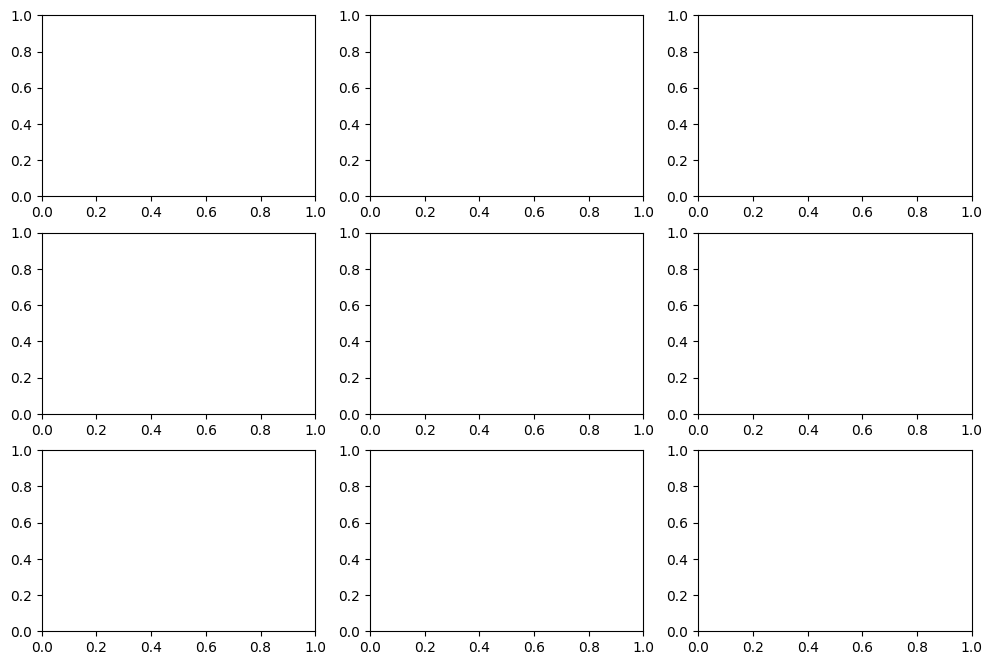

In [2]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) =  plt.subplots(3,3, figsize=(12, 8))

ax1.plot(cd1, label="Detailed Coefficient Level 1")
ax1.legend()

ax2.plot(cd2, label="Detailed Coefficient Level 2")
ax2.legend()

ax3.plot(cd3, label="Detailed Coefficient Level 3")
ax3.legend()

ax4.plot(cd4, label="Detailed Coefficient Level 4")
ax4.legend()

ax5.plot(cd5, label="Detailed Coefficient Level 5")
ax5.legend()

ax6.plot(cd6, label="Detailed Coefficient Level 6")
ax6.legend()

ax7.plot(cd7, label="Detailed Coefficient Level 7")
ax7.legend()

ax8.plot(cd8, label="Detailed Coefficient Level 8")
ax8.legend()

ax9.plot(ca9, label="Approximate Coefficient Level 9")
ax9.legend()

plt.savefig("coefficients", dpi=300)
plt.show()

#### 3.2 Thresholding

In [3]:
# threshold a1
def improved_threshold_a1(wavelet_coefficients, L):
    quantized_coefficients = np.zeros_like(wavelet_coefficients)
    for idx, coeff in np.ndenumerate(wavelet_coefficients):
        if abs(coeff) >= L:
            quantized_coefficients[idx] = np.sign(coeff) * ((abs(coeff)**2 - L**2)**0.5)
        else:
            quantized_coefficients[idx] = 0
    return quantized_coefficients

# threshold a2
def improved_threshold_a2(wavelet_coefficients, L):
    quantized_coefficients = np.zeros_like(wavelet_coefficients)
    for idx, coeff in np.ndenumerate(wavelet_coefficients):
        if abs(coeff) >= L:
            quantized_coefficients[idx] = np.sign(coeff) * (abs(coeff) - 2**(L - abs(coeff)))
        else:
            quantized_coefficients[idx] = 0
    return quantized_coefficients

# threshold a3
def improved_threshold_a3(wavelet_coefficients, L):
    quantized_coefficients = np.zeros_like(wavelet_coefficients)
    for idx, coeff in np.ndenumerate(wavelet_coefficients):
        if abs(coeff) >= L:
            quantized_coefficients[idx] = np.sign(coeff) * (abs(coeff) - (2*L) / (np.exp((abs(coeff) - L) / (L)) + 1))
        else:
            quantized_coefficients[idx] = 0
    return quantized_coefficients


In [252]:
thresholdLambda = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(x_noise)))
threshold_1 = [pywt.threshold(c, thresholdLambda, mode='soft') for c in coeffs]
threshold_2 = [pywt.threshold(c, thresholdLambda, mode='hard') for c in coeffs]
threshold_3 = [improved_threshold_a1(wavelet_coefficients=c, L=thresholdLambda) for c in coeffs]
threshold_4 = [improved_threshold_a2(wavelet_coefficients=c, L=thresholdLambda) for c in coeffs]
threshold_5 = [improved_threshold_a3(wavelet_coefficients=c, L=thresholdLambda) for c in coeffs]

#### 3.3 Reconstructing the Denoised Signal

We calculate the non-noise components $\vec{x}_{i}(t)$ corresponding to each thresholding functions $i$
$$
    \vec{x}_i(t) = \sum_{k=1}^{i} \text{IMF}_{k} - \epsilon_{i}(t)
$$

In [253]:
# noisefree components
x_vec_1 = pywt.waverec(threshold_1, chosen_wavelet)
x_vec_2 = pywt.waverec(threshold_2, chosen_wavelet)
x_vec_3 = pywt.waverec(threshold_3, chosen_wavelet)
x_vec_4 = pywt.waverec(threshold_4, chosen_wavelet)
x_vec_5 = pywt.waverec(threshold_5, chosen_wavelet)

# separate the noise component e(t):
epsilon_1 = x_noise - x_vec_1
epsilon_2 = x_noise - x_vec_2
epsilon_3 = x_noise - x_vec_3
epsilon_4 = x_noise - x_vec_4

#### 3.4 Plotting and Analyzing the Result

In [102]:
# clean_signal = clean_ret

# # soft thresholding
# mse_s = np.mean((clean_signal - x_vec_1) ** 2)
# rmse_s = np.sqrt(mse_s)
# mae_s = np.mean(np.abs(clean_signal - x_vec_1))
# max_value = np.max(clean_signal)
# psnr_s = 10 * np.log10(max_value ** 2 / mse_s)

# # hard thresholding
# mse_h = np.mean((clean_signal - x_vec_1) ** 2)
# rmse_h = np.sqrt(mse_h)
# mae_h = np.mean(np.abs(clean_signal - x_vec_1))
# psnr_h = 10 * np.log10(max_value ** 2 / mse_h)

# # print the results
# index_values = ["MSE", "RMSE", "MAE", "PSNR"]
# df = pd.DataFrame(index=index_values)
# df["soft"] = [mse_s, rmse_s, mae_s, psnr_s]
# df["hard"] = [mse_h, rmse_h, mae_h, psnr_h]
# print(df)

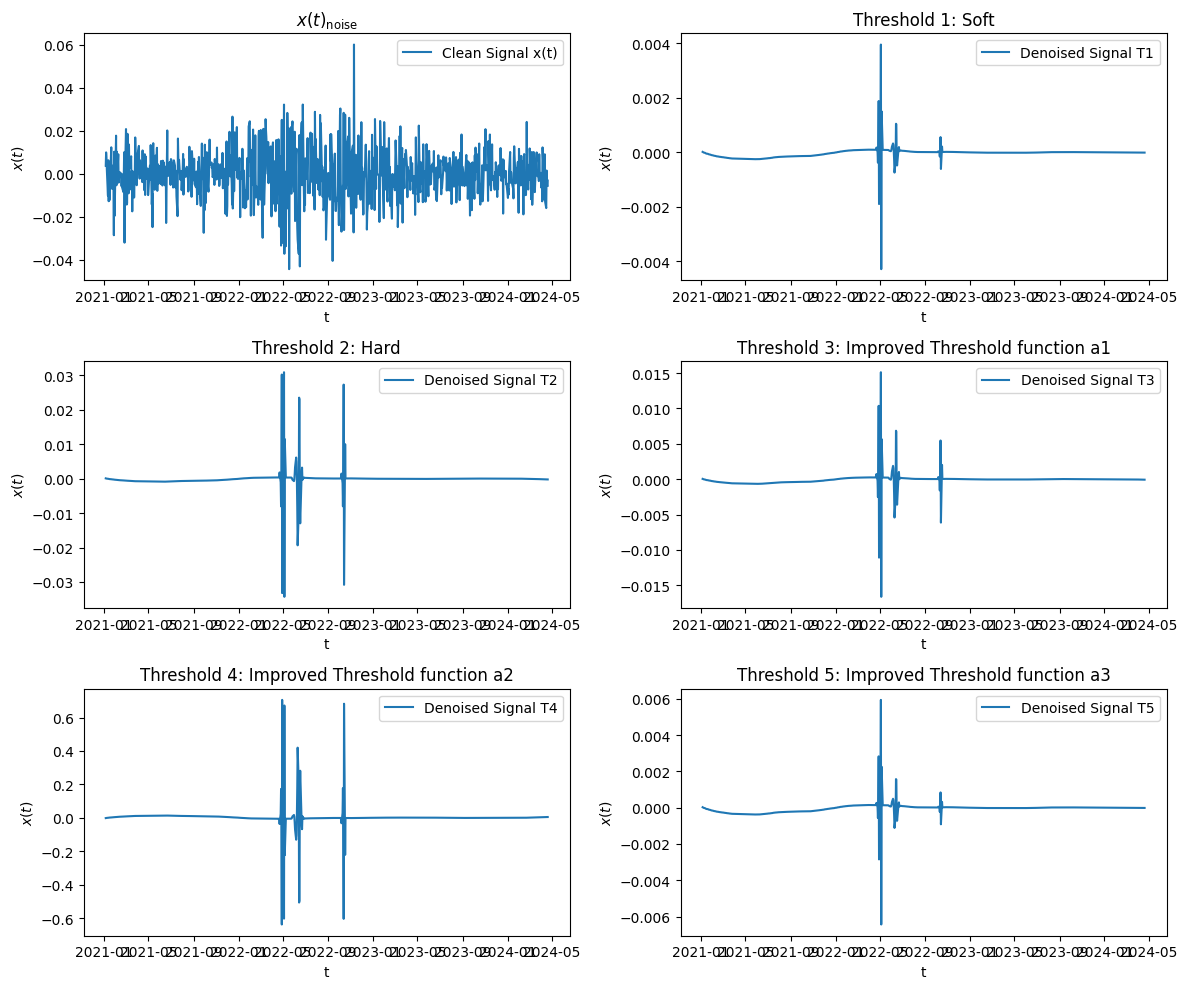

In [271]:
clean_signal = clean_ret

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) =  plt.subplots(3,2, figsize=(12, 10))

# true signal
ax1.plot(clean_ret.index, x_noise, label="Clean Signal x(t)")
ax1.set_title("$x(t)_{\\text{noise}}$")
ax1.set_xlabel("t")
ax1.set_ylabel("$x(t)$")
ax1.legend()

# threshold 1
ax2.plot(clean_ret.index, x_vec_1, label="Denoised Signal T1")
ax2.set_title("Threshold 1: Soft")
ax2.set_xlabel("t")
ax2.set_ylabel("$x(t)$")
ax2.legend()

# threshold 1
ax3.plot(clean_ret.index, x_vec_2, label="Denoised Signal T2")
ax3.set_title("Threshold 2: Hard")
ax3.set_xlabel("t")
ax3.set_ylabel("$x(t)$")
ax3.legend()

# threshold 1
ax4.plot(clean_ret.index, x_vec_3, label="Denoised Signal T3")
ax4.set_title("Threshold 3: Improved Threshold function a1")
ax4.set_xlabel("t")
ax4.set_ylabel("$x(t)$")
ax4.legend()

# threshold 1
ax5.plot(clean_ret.index, x_vec_4, label="Denoised Signal T4")
ax5.set_title("Threshold 4: Improved Threshold function a2")
ax5.set_xlabel("t")
ax5.set_ylabel("$x(t)$")
ax5.legend()

# threshold 1
ax6.plot(clean_ret.index, x_vec_5, label="Denoised Signal T5")
ax6.set_title("Threshold 5: Improved Threshold function a3")
ax6.set_xlabel("t")
ax6.set_ylabel("$x(t)$")
ax6.legend()

plt.tight_layout()
plt.legend()
plt.show()


$$
\begin{align*}
    x(t) &= \sum_{i=1}^{K} \text{IMF}_{k} + R(t) \\
         &= \underbrace{ x(t)_{\text{noise}}}_{\epsilon(t) + \vec{x}(t)} + x(t)_{\text{non\_noise}} \\
         &= \epsilon(t) + \underbrace{ \vec{x}(t) + x(t)_{\text{non\_noise}}}_{\tilde{x}(t)} \\
         &= \epsilon(t) + \tilde{x}(t)
\end{align*}
$$

This means our noisy signal $x(t)$ is made up of the noise $\epsilon(t)$ and the signal $\tilde{x}(t)$ 

In [254]:
# calculate the signal
x_tilde_1 = x_vec_1 + x_non_noise
x_tilde_2 = x_vec_2 + x_non_noise
x_tilde_3 = x_vec_3 + x_non_noise
x_tilde_4 = x_vec_4 + x_non_noise
x_tilde_5 = x_vec_5 + x_non_noise

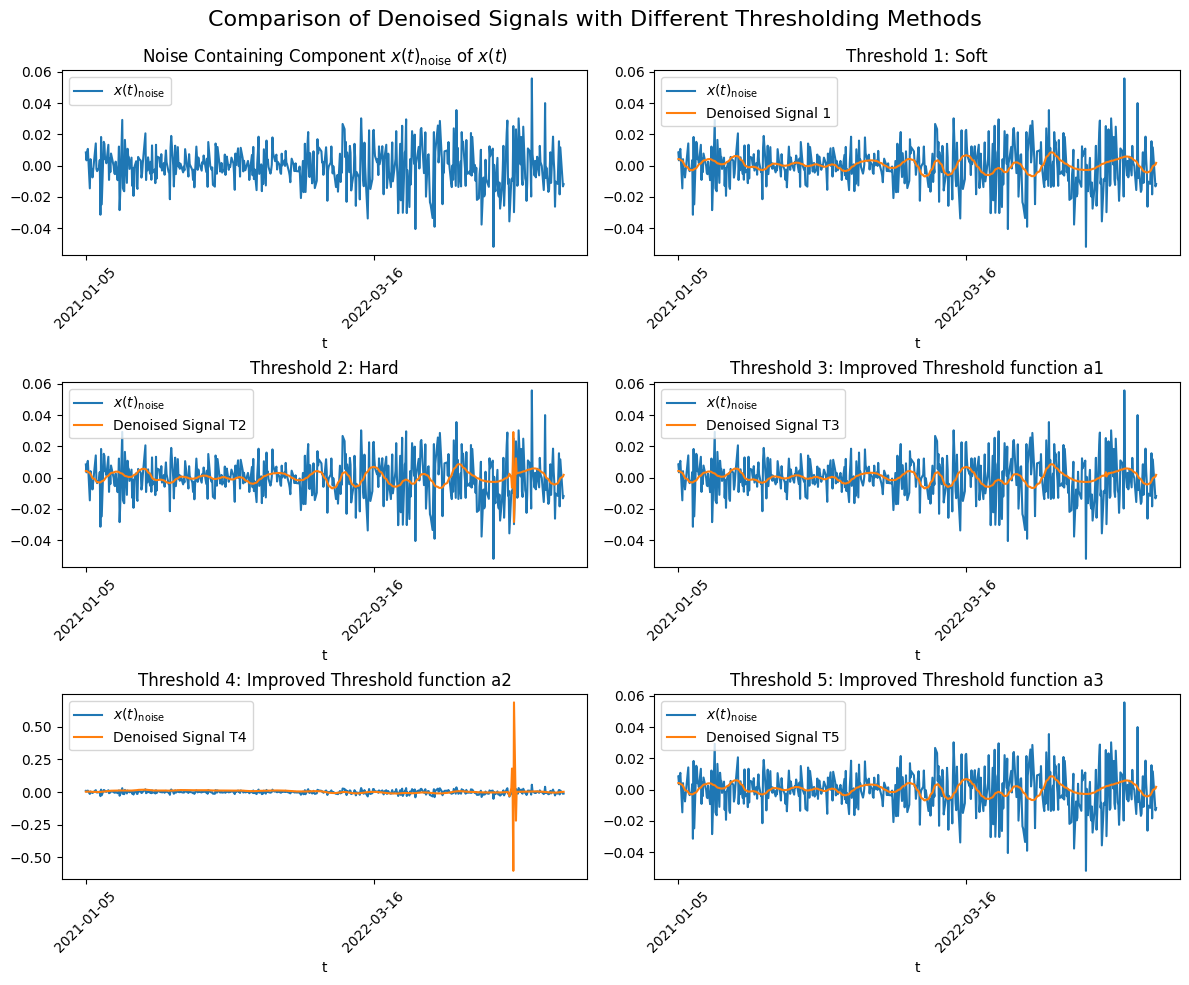

In [255]:
clean_signal = clean_ret
# num = len(clean_ret)
num = 500
n_dates = int(500 * num / len(clean_ret))


fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) =  plt.subplots(3,2, figsize=(12, 10))

# true signal
ax1.plot(clean_ret.index[:num], x_noise[:num], label="$x(t)_{\\text{noise}}$")
ax1.set_title("Noise Containing Component $x(t)_{\\text{noise}}$ of $x(t)$")
ax1.set_xlabel("t")
ax1.set_xticks(clean_ret.index[:num][::n_dates])
ax1.set_xticklabels(clean_ret.index[:num][::n_dates].date, rotation=45)
ax1.legend()

# denoised signal 1
ax2.plot(clean_ret.index[:num], x_noise[:num], label="$x(t)_{\\text{noise}}$")
ax2.plot(clean_ret.index[:num], x_tilde_1[:num], label="Denoised Signal 1")
ax2.set_title("Threshold 1: Soft")
ax2.set_xlabel("t")
ax2.set_xticks(clean_ret.index[:num][::n_dates])
ax2.set_xticklabels(clean_ret.index[:num][::n_dates].date, rotation=45)
ax2.legend()

# denoised signal 2
ax3.plot(clean_ret.index[:num], x_noise[:num], label="$x(t)_{\\text{noise}}$")
ax3.plot(clean_ret.index[:num], x_tilde_2[:num], label="Denoised Signal T2")
ax3.set_title("Threshold 2: Hard")
ax3.set_xlabel("t")
ax3.set_xticks(clean_ret.index[:num][::n_dates])
ax3.set_xticklabels(clean_ret.index[:num][::n_dates].date, rotation=45)
ax3.legend()

# denoised signal 3
ax4.plot(clean_ret.index[:num], x_noise[:num], label="$x(t)_{\\text{noise}}$")
ax4.plot(clean_ret.index[:num], x_tilde_3[:num], label="Denoised Signal T3")
ax4.set_title("Threshold 3: Improved Threshold function a1")
ax4.set_xlabel("t")
ax4.set_xticks(clean_ret.index[:num][::n_dates])
ax4.set_xticklabels(clean_ret.index[:num][::n_dates].date, rotation=45)
ax4.legend()

# denoised signal 4
ax5.plot(clean_ret.index[:num], x_noise[:num], label="$x(t)_{\\text{noise}}$")
ax5.plot(clean_ret.index[:num], x_tilde_4[:num], label="Denoised Signal T4")
ax5.set_title("Threshold 4: Improved Threshold function a2")
ax5.set_xlabel("t")
ax5.set_xticks(clean_ret.index[:num][::n_dates])
ax5.set_xticklabels(clean_ret.index[:num][::n_dates].date, rotation=45)
ax5.legend()

# denoised signal 5
ax6.plot(clean_ret.index[:num], x_noise[:num], label="$x(t)_{\\text{noise}}$")
ax6.plot(clean_ret.index[:num], x_tilde_5[:num], label="Denoised Signal T5")
ax6.set_title("Threshold 5: Improved Threshold function a3")
ax6.set_xlabel("t")
ax6.set_xticks(clean_ret.index[:num][::n_dates])
ax6.set_xticklabels(clean_ret.index[:num][::n_dates].date, rotation=45)
ax6.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.92)  
fig.suptitle("Comparison of Denoised Signals with Different Thresholding Methods", fontsize=16)
plt.legend()
plt.show()


In [259]:
print(f"snr threshold4: {get_snr(clean_ret, x_tilde_1)}")
print(f"snr threshold4: {get_snr(clean_ret, x_tilde_2)}")
print(f"snr threshold4: {get_snr(clean_ret, x_tilde_3)}")
print(f"snr threshold4: {get_snr(clean_ret, x_tilde_4)}")
print(f"snr threshold4: {get_snr(clean_ret, x_tilde_5)}")
print(f"noisy returns: {get_snr(clean_ret, ret)}")

snr threshold4: 1.0446693866746097
snr threshold4: 1.0611951579111876
snr threshold4: 1.045673101114738
snr threshold4: 0.08676815585064364
snr threshold4: 1.0443261908561097
noisy returns: 10.43592706821269


In [258]:
print(f"snr threshold4: {get_snr(clean_ret, x_tilde_1)}")
print(f"snr threshold4: {get_snr(clean_ret, x_tilde_2)}")
print(f"snr threshold4: {get_snr(clean_ret, x_tilde_3)}")
print(f"snr threshold4: {get_snr(clean_ret, x_tilde_4)}")
print(f"snr threshold4: {get_snr(clean_ret, x_tilde_5)}")
print(f"noisy returns: {get_snr(clean_ret, ret)}")

snr threshold4: 1.0446693866746097
snr threshold4: 1.0611951579111876
snr threshold4: 1.045673101114738
snr threshold4: 0.08676815585064364
snr threshold4: 1.0443261908561097
noisy returns: 10.43592706821269


## 4. Calculate the Euclidean distances

the similarity measure $D(x_i, x_j)$ between time series $x_i(t)$ and $x_j(t)$ is a function that takes two time series $x_i(t)$ and $x_j(t)$ as inputs and returns the distance $d$ between the two time series.
$$
    D(x_i, x_j) = \sqrt{\sum_{k=1}^{n}(x_{ik}-x_{jk})^2}
$$

# 5. Class 

In [10]:
class StockData():
    def __init__(self, ticker, start_dt, end_dt):
        self.ticker = ticker
        self.start_dt = start_dt
        self.end_dt = end_dt
        self._clean_ret = None  
        self._noisy_ret = None  

    def calculate_returns(self, data):
        returns = data.pct_change()
        returns = returns.dropna()
        return returns

    def returns(self, add_noise=False, noise_mean=0, noise_std_dev=1):
        if (self._clean_ret is None and add_noise==False) or (self._noisy_ret is None and add_noise==True):
            data = yf.download(self.ticker, start=self.start_dt, end=self.end_dt)["Adj Close"]
            if add_noise==False:
                    self._clean_ret = self.calculate_returns(data)
            else:
                num_samples = len(data)
                gaussian_noise = np.random.normal(noise_mean, noise_std_dev, num_samples)
                noisy_data = data + gaussian_noise
                self._noisy_ret = self.calculate_returns(noisy_data)
                
        if add_noise==False:
            return self._clean_ret
        else:
            return self._noisy_ret

    def get_snr(self, clean_signal, noisy_signal):
        clean_signal_power = np.mean(clean_signal**2)
        noise = clean_signal - noisy_signal
        noisy_signal_power = np.mean(noise**2)
        return clean_signal_power / noisy_signal_power


In [11]:
class ICEEMDAN_denoise():
    def __init__(self, clean_data, noisy_data):
        self.clean_ret = clean_data
        self.noisy_ret = noisy_data

        self._get_IMFs = None
        self._get_separation_point = None\

    # calculate IMFs:
    def get_imfs(self):
        if self._get_IMFs is None:
            s = self.noisy_ret.values
            t = self.noisy_ret.index

            # Execute EEMD on s
            ceemdan = CEEMDAN()
            c_IMF = ceemdan(s)
            nCIMF = c_IMF.shape[0]
            IMFs = c_IMF
            sum_IMFs = np.sum(IMFs, axis=0)
            R = s - sum_IMFs 
            self._get_IMFs = IMFs, R
            return self._get_IMFs
        else:
            return self._get_IMFs

    # test for zero mean:
    def population_mean_test(self, data, alpha=0.01):
        x_bar = np.mean(data)
        s = np.std(data)
        n = len(data)
        t_statistic = x_bar / (s / np.sqrt(n))

        # calculate critical values   
        t_critical_lower = stats.t.ppf(alpha/2, n-1)
        t_critical_upper = stats.t.ppf(1-alpha/2, n-1)
        
        return (t_statistic >= t_critical_lower and t_statistic <= t_critical_upper)
    
    # test for stationarity (ADF):
    def adf_test(self, data, alpha=0.01):
        result = adfuller(data)
        p_value = result[1]
        return p_value < alpha

    # find the separation point:
    def get_separation_point(self):
        if self._get_separation_point is None:
            separation_point = None
            test_results = []
            IMFs, R = self.get_imfs()

            # Iterate over possible separation points
            for i in range(1, len(IMFs)):
                # Condition 1: Population mean test for each IMF component
                condition_1 = all(self.population_mean_test(imf) for imf in IMFs[:i])
                
                # Condition 2: Population mean test for the sum of IMF components
                condition_2 = self.population_mean_test(np.sum(IMFs[:i], axis=0))
                
                # Condition 3: ADF test for each IMF component
                condition_3 = all(self.adf_test(imf) for imf in IMFs[:i])
                
                # Condition 4: ADF test for the sum of IMF components
                condition_4 = self.adf_test(np.sum(IMFs[:i], axis=0))
                
                # Store the test results
                test_results.append((i, condition_1, condition_2, condition_3, condition_4))

            # Find the separation point that satisfies all conditions
            for i, condition_1, condition_2, condition_3, condition_4 in test_results:
                if condition_1 and condition_2 and condition_3 and condition_4:
                    continue
                else:
                    separation_point = i-1
                    break
            self._get_separation_point = separation_point
        return self._get_separation_point

    # separate into x_noise and x_non_noise:
    def get_x_noise(self):
        separation_point = self.get_separation_point()
        IMFs, _ = self.get_imfs()
        return np.sum(IMFs[:separation_point+1], axis=0)

        # IMFs, R = self.get_imfs()
        # return np.sum(IMFs[separation_point:], axis=0) + R



    def get_x_non_noise(self):
        separation_point = self.get_separation_point()
        IMFs, R = self.get_imfs()
        return np.sum(IMFs[separation_point:], axis=0) + R

        # IMFs, _ = self.get_imfs()
        # return np.sum(IMFs[:separation_point+1], axis=0)
        

    # different threshold values:
    def rigrsure(self, coeffs, noise_std_dev):
        # Initialize an empty list to store the risk values for each coefficient array
        risks = []
        
        # Loop through each coefficient array
        for coeff in coeffs:
            # Calculate the squared magnitudes of the wavelet coefficients
            coeff_sq = np.abs(coeff) ** 2
            
            # Calculate the number of coefficients
            N = coeff.size
            
            # Calculate the squared norm of the coefficients
            sq_norm = np.sum(coeff_sq)
            
            # Calculate the threshold value using rigrsure rule
            threshold = np.sqrt(sq_norm) * np.sqrt(2 * np.log(N))
            
            # Calculate the risk using rigrsure formula
            risk = N * noise_std_dev ** 2 - sq_norm + 2 * N * noise_std_dev ** 2
            
            # Append the risk value to the list
            risks.append(risk)
        
        # Return the list of risk values
        return risks

        return thresholded_coeffs

    def heursure(self, coeffs, noise_std_dev):
        # Initialize an empty list to store the threshold values for each coefficient array
        thresholds = []
        
        # Loop through each coefficient array
        for coeff in coeffs:
            # Calculate the threshold value using Heursure method
            threshold = np.sqrt(2 * np.log(len(coeff))) * noise_std_dev
            thresholds.append(threshold)
        
        # Return the list of threshold values
        return thresholds
    
    def minimax(self, coeffs, noise_std_dev):
        # Initialize an empty list to store the threshold values for each coefficient array
        thresholds = []
        
        # Loop through each coefficient array
        for coeff in coeffs:
            # Calculate the threshold value using Minimax method
            threshold = np.sqrt(2 * np.log(len(coeff))) * noise_std_dev / 0.6745
            thresholds.append(threshold)
        
        # Return the list of threshold values
        return thresholds

    def sqtwolog(self, coeffs, noise_std_dev):
        # Initialize an empty list to store the threshold values for each coefficient array
        thresholds = []
        
        # Loop through each coefficient array
        for coeff in coeffs:
            # Calculate the threshold value using Sqtwolog method
            threshold = np.sqrt(2 * np.log(len(coeff))) * noise_std_dev
            thresholds.append(threshold)
        
        # Return the list of threshold values
        return thresholds

    def wavelet_denoising(self, wavelet='db4', decomp_level=4, threshold_mode='soft', threshold_value='other'):
        # 1. decomposition into IMFs:
        x_noise = self.get_x_noise()
        coeffs = pywt.wavedec(x_noise, wavelet, level=decomp_level)  

        # 2. thresholding
        if threshold_value=="sqtwolog":
            thresholdLambda = self.sqtwolog(coeffs, np.std(x_noise))
        elif threshold_value=="rigrsure":
            thresholdLambda = self.rigrsure(coeffs, np.std(x_noise))
        elif threshold_value=="heursure":
            thresholdLambda = self.heursure(coeffs, np.std(x_noise))
        elif threshold_value=="minimax":
            thresholdLambda = self.minimax(coeffs, np.std(x_noise))
        else:
            thresholdLambda = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(x_noise)))
            

        # calculate threshold coefficients
        if threshold_mode in ['soft', 'hard', 'garrote', 'greater', 'less']:
            if threshold_value=="other":
                threshold = [pywt.threshold(c, thresholdLambda, mode=threshold_mode) for c in coeffs]
            else:
                threshold = [pywt.threshold(c, t, mode=threshold_mode) for c, t in zip(coeffs, thresholdLambda)]
        else:
            if threshold_value=="other":
                threshold = [threshold_mode(wavelet_coefficients=c, L=thresholdLambda) for c in coeffs]
            else:
                threshold = [threshold_mode(wavelet_coefficients=c, L=t) for c,t in zip(coeffs, thresholdLambda)]

        # 3. inverse wavelet transform:
        x_vec = pywt.waverec(threshold, wavelet)

        # 4. separate the noise component from the x_noise:
        epsilon = x_noise - x_vec

        # 4. combine both the non-noise components:
        x_tilde = self.get_x_non_noise() + x_vec

        return x_tilde

    def get_snr(self, cleaned_signal):
        clean_signal = self.clean_ret
        noisy_signal = self.noisy_ret
        clean_signal_power = np.sqrt(np.sum(np.square(clean_signal)))

        noisy_noise = clean_signal - noisy_signal
        noisy_signal_power = np.sqrt(np.sum(np.square(noisy_noise)))

        cleaned_noise = clean_signal - cleaned_signal
        cleaned_signal_power = np.sqrt(np.sum(np.square(cleaned_noise)))

        return clean_signal_power/noisy_signal_power, clean_signal_power/cleaned_signal_power


In [12]:
# get the data:
stock_data = StockData(ticker="^GSPC", start_dt = "2001-01-01", end_dt = "2024-04-20")
clean_ret = stock_data.returns(add_noise=False)
noisy_ret = stock_data.returns(add_noise=True, noise_mean=0, noise_std_dev=30)
snr_noisy = stock_data.get_snr(clean_ret, noisy_ret)

ID = ICEEMDAN_denoise(clean_data=clean_ret, noisy_data=noisy_ret)

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


In [13]:
x_tilder_r = ID.wavelet_denoising(wavelet='coif17', decomp_level=4, threshold_mode='soft', threshold_value='minimax')
snr = ID.get_snr(x_tilder_r)
print(snr)

(0.418957630174705, 0.999073265348152)


In [15]:
(snr[1]-snr[0])/snr[0]*100

138.46642080048505

In [27]:
wavelets = pywt.wavelist(kind='discrete')
res = dict()
for wavelet in wavelets:
    x_tilde_s = ID.wavelet_denoising(wavelet=wavelet, decomp_level=8, threshold_mode='soft', threshold_value="rigrsure"); # print(f"SNR: {ID.get_snr(x_tilde_h)}")
    snr = ID.get_snr(x_tilde_h)
    res[wavelet] = snr

top_10_wavelets = sorted(res, key=res.get, reverse=True)[:10]
for wavelet in top_10_wavelets:
    print(f"{wavelet}: {res[wavelet]}")

/home/sid/Yandex.Disk/Academics/Universities/3. Stony Brook/Physics/Current Courses/Spring 2024/AMS 515 Cases in ML in Finance/project_report/wavelet_denoising/env_wavelets/lib/python3.10/site-packages/pywt/_thresholding.py:24: RuntimeWarning: invalid value encountered in multiply
  thresholded = data * thresholded


bior1.1: (0.418957630174705, 1.0233665507454803)
bior1.3: (0.418957630174705, 1.0233665507454803)
bior1.5: (0.418957630174705, 1.0233665507454803)
bior2.2: (0.418957630174705, 1.0233665507454803)
bior2.4: (0.418957630174705, 1.0233665507454803)
bior2.6: (0.418957630174705, 1.0233665507454803)
bior2.8: (0.418957630174705, 1.0233665507454803)
bior3.1: (0.418957630174705, 1.0233665507454803)
bior3.3: (0.418957630174705, 1.0233665507454803)
bior3.5: (0.418957630174705, 1.0233665507454803)


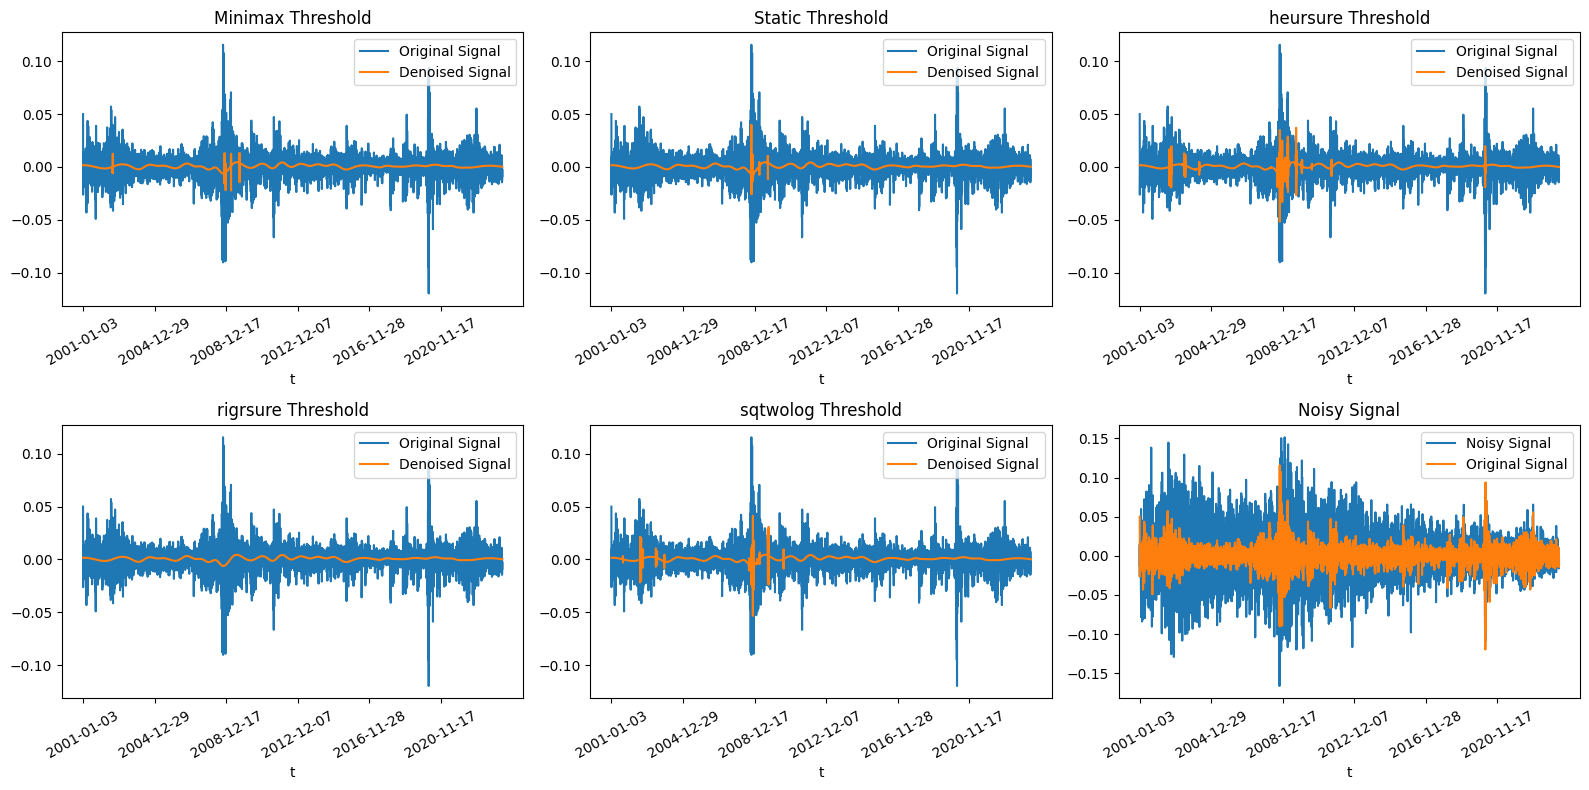

In [40]:
x_tilde_m = ID.wavelet_denoising(wavelet='rbio2.8', decomp_level=8, threshold_mode='soft', threshold_value="minimax")
x_tilde_o = ID.wavelet_denoising(wavelet='bior2.4', decomp_level=8, threshold_mode='soft', threshold_value="other")
x_tilde_h = ID.wavelet_denoising(wavelet='db9', decomp_level=8, threshold_mode='soft', threshold_value="heursure")
x_tilde_r = ID.wavelet_denoising(wavelet='bior1.1', decomp_level=8, threshold_mode='soft', threshold_value="rigrsure")
x_tilde_s = ID.wavelet_denoising(wavelet='bior1.1', decomp_level=8, threshold_mode='soft', threshold_value="sqtwolog")

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) =  plt.subplots(2,3, figsize=(16, 8))

num=len(clean_ret)
n_dates = 1000

ax1.plot(clean_ret.index[:num], clean_ret.values[:num], label="Original Signal")
ax1.plot(clean_ret.index[:num], x_tilde_m[:num], label="Denoised Signal")
ax1.set_title("Minimax Threshold")
ax1.set_xlabel("t")
ax1.set_xticks(clean_ret.index[:num][::n_dates])
ax1.set_xticklabels(clean_ret.index[:num][::n_dates].date, rotation=30)
ax1.legend()

ax2.plot(clean_ret.index[:num], clean_ret.values[:num], label="Original Signal")
ax2.plot(clean_ret.index[:num], x_tilde_o[:num], label="Denoised Signal")
ax2.set_title("Static Threshold")
ax2.set_xlabel("t")
ax2.set_xticks(clean_ret.index[:num][::n_dates])
ax2.set_xticklabels(clean_ret.index[:num][::n_dates].date, rotation=30)
ax2.legend()

ax3.plot(clean_ret.index[:num], clean_ret.values[:num], label="Original Signal")
ax3.plot(clean_ret.index[:num], x_tilde_h[:num], label="Denoised Signal")
ax3.set_title("heursure Threshold")
ax3.set_xlabel("t")
ax3.set_xticks(clean_ret.index[:num][::n_dates])
ax3.set_xticklabels(clean_ret.index[:num][::n_dates].date, rotation=30)
ax3.legend()

ax4.plot(clean_ret.index[:num], clean_ret.values[:num], label="Original Signal")
ax4.plot(clean_ret.index[:num], x_tilde_r[:num], label="Denoised Signal")
ax4.set_title("rigrsure Threshold")
ax4.set_xlabel("t")
ax4.set_xticks(clean_ret.index[:num][::n_dates])
ax4.set_xticklabels(clean_ret.index[:num][::n_dates].date, rotation=30)
ax4.legend()

ax5.plot(clean_ret.index[:num], clean_ret.values[:num], label="Original Signal")
ax5.plot(clean_ret.index[:num], x_tilde_s[:num], label="Denoised Signal")
ax5.set_title("sqtwolog Threshold")
ax5.set_xlabel("t")
ax5.set_xticks(clean_ret.index[:num][::n_dates])
ax5.set_xticklabels(clean_ret.index[:num][::n_dates].date, rotation=30)
ax5.legend()

ax6.plot(clean_ret.index[:num], noisy_ret[:num], label="Noisy Signal")
ax6.plot(clean_ret.index[:num], clean_ret.values[:num], label="Original Signal")
ax6.set_title("Noisy Signal")
ax6.set_xlabel("t")
ax6.set_xticks(clean_ret.index[:num][::n_dates])
ax6.set_xticklabels(clean_ret.index[:num][::n_dates].date, rotation=30)
ax6.legend()

plt.tight_layout()
plt.savefig("result", dpi=300)
plt.show()

In [293]:
IMF_noise = IMFs[:separation_point+1]
IMF_non_noise = IMFs[separation_point+1:]
for imf in IMFs:
    energy = np.sum(i**2 for i in imf)
    print(energy)

0.07516011610586416
0.024417632473572266
0.012419697201026524
0.006059021429213534
0.0015079918897600612
0.0009868813169133937
0.0005577414564601895
1.7164122599783013e-06
0.0006441673612153216


/tmp/ipykernel_647412/3489709766.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  energy = np.sum(i**2 for i in imf)


In [294]:
x_tilde = ID.wavelet_denoising(wavelet='db4', decomp_level=4, threshold_mode='soft', threshold_value="other")
x_tilde_r = ID.wavelet_denoising(wavelet='db4', decomp_level=4, threshold_mode='soft', threshold_value="rigrsure")
x_tilde_h = ID.wavelet_denoising(wavelet='db4', decomp_level=4, threshold_mode='soft', threshold_value="heursure")
x_tilde_m = ID.wavelet_denoising(wavelet='db4', decomp_level=4, threshold_mode='soft', threshold_value="minimax")
x_tilde_s = ID.wavelet_denoising(wavelet='db4', decomp_level=4, threshold_mode='soft', threshold_value="sqtwolog")

In [295]:
print(f"other: {ID.get_snr(x_tilde)}")
print(f"r: {ID.get_snr(x_tilde_r)}")
print(f"h: {ID.get_snr(x_tilde_h)}")
print(f"m: {ID.get_snr(x_tilde_m)}")
print(f"s: {ID.get_snr(x_tilde_s)}")

other: (0.4170908072536185, 0.9996267802399994)
r: (0.4170908072536185, 0.9992032137530928)
h: (0.4170908072536185, 1.006292072239538)
m: (0.4170908072536185, 0.9992032137530928)
s: (0.4170908072536185, 1.006292072239538)


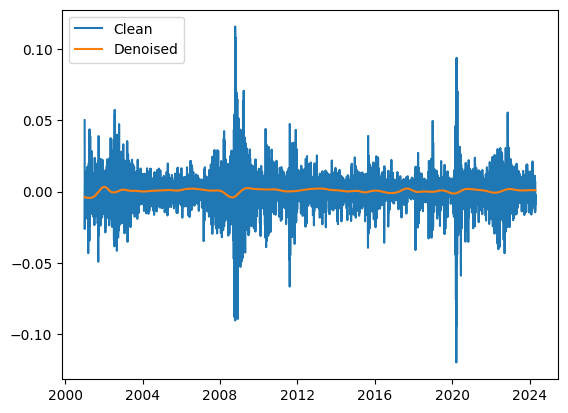

In [299]:
num = len(clean_ret)
plt.plot(clean_ret.index[:num], clean_ret.values[:num], label="Clean")
plt.plot(clean_ret.index[:num], x_tilde_m[:num], label="Denoised")
# plt.plot(clean_ret.index[:num], x_tilde_r[:num], label="rigrsure")
# plt.plot(clean_ret.index[:num], x_tilde_h[:num], label="heursure")
# plt.plot(clean_ret.index[:num], x_tilde_m[:num], label="minimax")
# plt.plot(clean_ret.index[:num], x_tilde_s[:num], label="sqtwolog")

plt.legend()

In [300]:
# builtin-thresholds
x_tilde_soft = ID.wavelet_denoising(wavelet='db4', decomp_level=4, threshold_mode='soft')
x_tilde_hard = ID.wavelet_denoising(wavelet='db4', decomp_level=4, threshold_mode='hard')
x_tilde_garrote = ID.wavelet_denoising(wavelet='db4', decomp_level=4, threshold_mode='garrote')
x_tilde_greater = ID.wavelet_denoising(wavelet='db4', decomp_level=4, threshold_mode='greater')
x_tilde_less = ID.wavelet_denoising(wavelet='db4', decomp_level=4, threshold_mode='less')

# improved thresholds:
x_tilde_a1 = ID.wavelet_denoising(wavelet='db4', decomp_level=4, threshold_mode=improved_threshold_a1)
x_tilde_a2 = ID.wavelet_denoising(wavelet='db4', decomp_level=4, threshold_mode=improved_threshold_a2)
x_tilde_a3 = ID.wavelet_denoising(wavelet='db4', decomp_level=4, threshold_mode=improved_threshold_a3)

In [301]:
# signal-to-noise ratio of different thresholds:
snr_soft = ID.get_snr(x_tilde_soft); print(f"soft: {snr_soft}")
snr_hard = ID.get_snr(x_tilde_hard); print(f"hard: {snr_hard}")
snr_garrote = ID.get_snr(x_tilde_garrote); print(f"garrote: {snr_garrote}")
snr_greater = ID.get_snr(x_tilde_greater); print(f"greater: {snr_greater}")
snr_less = ID.get_snr(x_tilde_less); print(f"less: {snr_less}")
snr_a1 = ID.get_snr(x_tilde_a1); print(f"a1: {snr_a1}")
snr_a2 = ID.get_snr(x_tilde_a2); print(f"a2: {snr_a2}")
snr_a3 = ID.get_snr(x_tilde_a3); print(f"a3: {snr_a3}")

soft: (0.4170908072536185, 0.9996267802399994)
hard: (0.4170908072536185, 0.9782984384567689)
garrote: (0.4170908072536185, 0.9999383990107518)
greater: (0.4170908072536185, 0.9904405249005661)
less: (0.4170908072536185, 0.417548096448105)
a1: (0.4170908072536185, 1.000238505087733)
a2: (0.4170908072536185, 0.6122155684803258)
a3: (0.4170908072536185, 0.999801641303653)


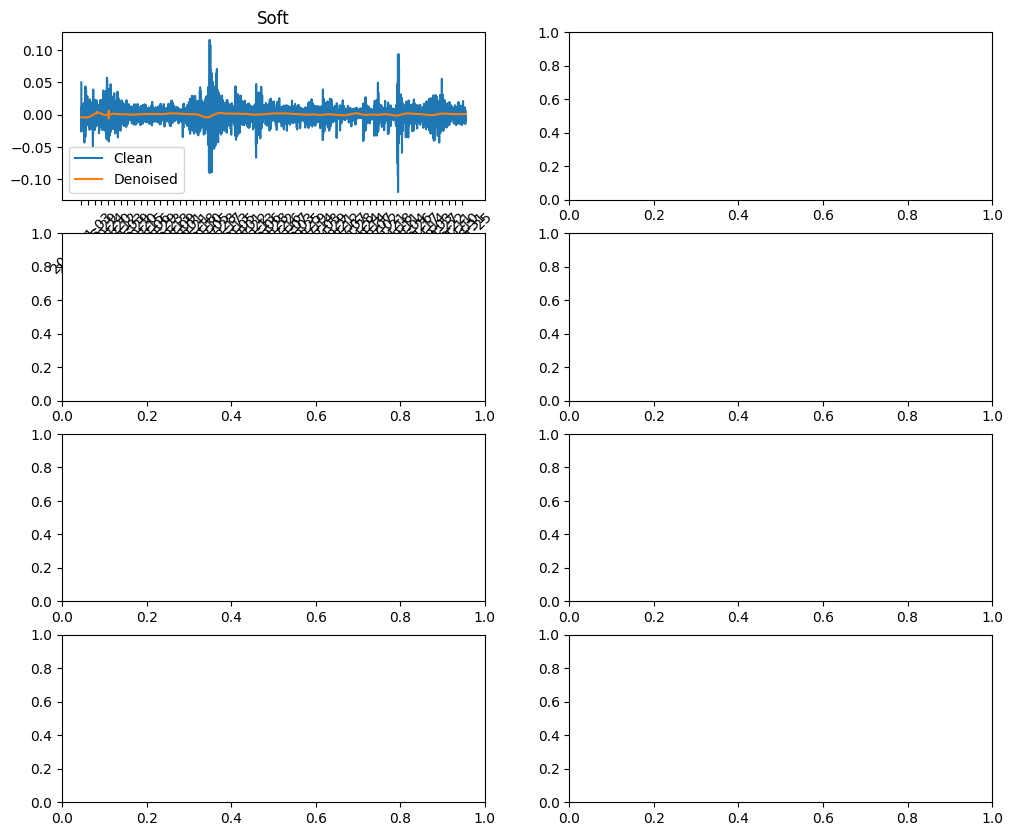

In [302]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) =  plt.subplots(4,2, figsize=(12, 10))

num=len(clean_ret)
n_dates = 100
# true signal
ax1.plot(clean_ret.index[:num], clean_ret.values[:num], label="Clean")
ax1.plot(clean_ret.index[:num], x_tilde_soft[:num], label="Denoised")
ax1.set_title("Soft")
ax1.set_xlabel("t")
ax1.set_xticks(clean_ret.index[:num][::n_dates])
ax1.set_xticklabels(clean_ret.index[:num][::n_dates].date, rotation=45)
ax1.legend()

ax1.plot(clean_ret.index[:num], clean_ret.values[:num], label="Clean")
ax1.plot(clean_ret.index[:num], x_tilde_soft[:num], label="Denoised")
ax1.set_title("Soft")
ax1.set_xlabel("t")
ax1.set_xticks(clean_ret.index[:num][::n_dates])
ax1.set_xticklabels(clean_ret.index[:num][::n_dates].date, rotation=45)
ax1.legend()
